<a href="https://colab.research.google.com/github/jaadu-1/Algo-trading/blob/main/project_bcd_signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor


In [1]:
# --- Data Generation ---
def generate_data(m=50, n=100, sparsity=10, noise_level=0.01):
    A = np.random.randn(m, n)
    theta_true = np.zeros(n)
    idx = np.random.choice(n, sparsity, replace=False)
    theta_true[idx] = np.random.rand(sparsity)
    y = A @ theta_true + noise_level * np.random.randn(m)
    return A, y, theta_true

In [3]:
# --- Projection onto [0, 1] box ---
def project_box(x):
    return np.clip(x, 0, 1)


In [4]:
# --- Gradient ---
def compute_gradient(A, y, theta):
    return -A.T @ (y - A @ theta)

In [5]:
# --- ML model to predict learning rate (trained offline) ---
def train_lr_model(A, y, theta_true):
    # Generate synthetic training data (can be more sophisticated)
    X, y_lr = [], []
    for _ in range(200):
        theta = np.random.rand(A.shape[1])
        grad = compute_gradient(A, y, theta)
        residual = np.linalg.norm(y - A @ theta)
        X.append([np.linalg.norm(grad), residual])
        y_lr.append(0.01 + 0.02 * np.random.rand())  # Simulate "good" lrs
    model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=3000)
    model.fit(X, y_lr)
    return model

In [6]:
# --- Projected BCD with ML-learned learning rate ---
def projected_bcd_ml(A, y, theta_init, num_iters=50, block_size=10, lr_model=None):
    n = theta_init.shape[0]
    theta = theta_init.copy()
    objective_vals = []

    for it in range(num_iters):
        for i in range(0, n, block_size):
            block = slice(i, min(i + block_size, n))
            grad = compute_gradient(A, y, theta)
            grad_block = grad[block]
            residual = np.linalg.norm(y - A @ theta)

            # Predict learning rate from ML model
            if lr_model:
                lr = lr_model.predict([[np.linalg.norm(grad_block), residual]])[0]
            else:
                lr = 0.01  # fallback

            theta[block] -= lr * grad_block
            theta[block] = project_box(theta[block])

        obj_val = np.linalg.norm(y - A @ theta)**2
        objective_vals.append(obj_val)

    return theta, objective_vals

In [7]:
# --- Plotting ---
def plot_convergence(objective_vals):
    plt.plot(objective_vals, label='ML-Projected BCD')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("ML-Guided Projected BCD for Sparse Signal Recovery")
    plt.grid(True)
    plt.legend()
    plt.show()

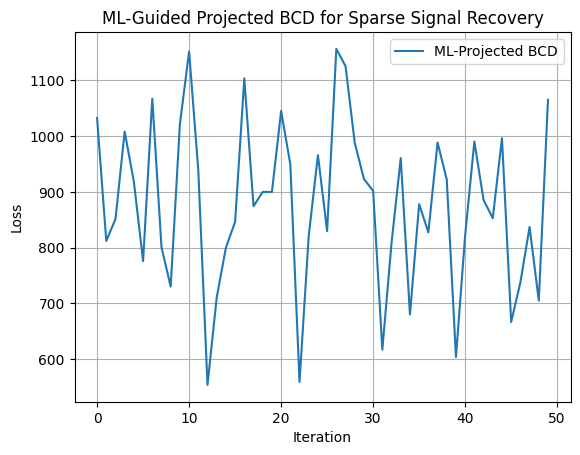

In [8]:
# --- Run Experiment ---
A, y, theta_true = generate_data()
theta_init = np.zeros(A.shape[1])
lr_model = train_lr_model(A, y, theta_true)
theta_est, obj_vals = projected_bcd_ml(A, y, theta_init, lr_model=lr_model)
plot_convergence(obj_vals)


In [9]:
# --- Evaluate ---
recovery_error = np.linalg.norm(theta_est - theta_true) / np.linalg.norm(theta_true)
print(f"Recovery error: {recovery_error:.4f}")


Recovery error: 3.5199
